In [1]:
import xarray as xr
import pandas as pd
import os
import re
import sys
import glob
import pathlib
import datetime
import numpy as np
import scipy
import easygems.healpix as egh
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})
import logging
from my_library.track_analyses import helpers
import pathlib
import matplotlib.pyplot as plt
import global3d_track as g3d
src = g3d.scripts.src

In [2]:
datadir = pathlib.Path(f'/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/')
savedir = pathlib.Path('../../extra_figures')
dpi = 300
ext = 'pdf'

In [3]:
df = pd.read_csv('/work/bb1153/b382635/plots/tracked_results_2025/canvil_paper/remakes_Aug2025/results_data/system_validity.csv', index_col='system_id')
invalid = df.index[df.hits_boundary]

In [4]:
# load sample of clouds
df = pd.read_csv(datadir / 'system_validity.csv', index_col='system_id')
invalid_convection = (df.n_cores_above_freezing / df.n_cores) == 1
invalid_rule = df.hits_boundary | invalid_convection
invalid = df.index[invalid_rule]

fdir = f'/work/bb1153/b382635/data/track_statistics/updraft_ice_only/amazon/system-wise/fcsfirst/'
variables = ['anvil_w','core_w']
ds = helpers.load_stats(fdir, variables, sidx_ignore=invalid, n_clouds=500)

In [5]:
# view typical
fdir = '/work/bb1153/b382635/data/final_tracks/updraft_ice_only/amazon/data_filtering_stats/system_anvil_base_height.csv'
abhs = pd.read_csv(fdir, index_col='system_id').rename(columns={'0':'level'})

In [6]:
# combine
cloud_w = xr.where(ds.anvil_w > 0, ds.anvil_w, ds.core_w).mean('core')
results = xr.Dataset({'w':cloud_w,
                      'dwdz':src.utils.definitions.derivative(cloud_w)
                     })

In [7]:
# load height coords
t_profile = xr.open_dataset(datadir / 'domain_mean_temperature_profile.nc')
results['zg_mu'] = t_profile.z_mean.sel(level_full=results.level_full)
results = results.set_coords('zg_mu')

In [8]:
# view result

NameError: name 'savdir' is not defined

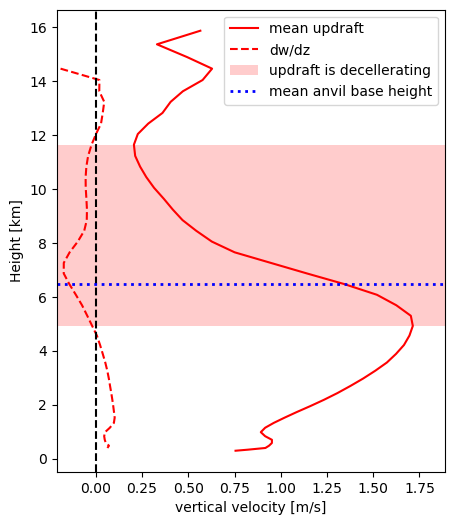

In [9]:
# mean results
d = results.mean(('time','system'))
abh = abhs.loc[results.system.values,'level'].mean()

# view
fig, ax = plt.subplots(figsize=(5,6,))

# vertical velocity
xlims = np.min(d.dwdz)*1.1, np.max(d.w)*1.1
d.w.plot(ax=ax, y='zg_mu', c='r', label='mean updraft')
d.dwdz.plot(ax=ax, y='zg_mu', ls='--', c='r', label='dw/dz')
decel = d.dwdz <= 0
ax.fill_betweenx(d.zg_mu, *xlims, where=decel, fc='red', ec='none', 
                 alpha=0.2, label='updraft is decellerating')
ax.axvline(0,c='k',ls='--')
ax.set(xlabel='vertical velocity [m/s]')

# ABH
ax.axhline(results.zg_mu.sel(level_full=abh, method='nearest'), ls=':', c='b', lw=2, label='mean anvil base height')

# axes
ax.set_title('')
ax.set(xlim=xlims, ylabel='Height [km]')
ax.legend()

# fig.savefig(savdir / f'anvil_base_height.{ext}', dpi=dpi)